In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import LSTM, Dense
from sklearn.metrics import r2_score
from sqlalchemy import create_engine
from keras.models import load_model
from keras.models import Sequential
import matplotlib.pyplot as plt
from datetime import datetime 
import tensorflow as tf
from numpy import NaN
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import psycopg2
import urllib
import os

<font size="30">Connect to the database</font>


In [2]:
#connect to the database
conn = psycopg2.connect(database='Value_Added_data_drought',
                        user="postgres",
                        password="1!qaz2@wsx",
                        host="140.134.51.64",
                        port="5432")

engine = create_engine('postgresql+psycopg2://postgres:%s@140.134.51.64/Value_Added_data_drought'%urllib.parse.quote_plus('1!qaz2@wsx'))

cur = conn.cursor()

<font size="30">data processing(2010/01/01-2022/12/31)</font>


In [3]:
#data cleaning process
def data_processing(dataset) -> pd.DataFrame:
    dataset['date'] = pd.to_datetime(dataset['date'], format='%Y-%m-%d')
    start_date = pd.to_datetime('2010-01-01')
    end_date = pd.to_datetime('2022-12-31')
    dataset_2020_2022 = dataset.query('date >= @start_date and date <= @end_date')
    dataset_2020_2022 = dataset_2020_2022[['date','grid','value']]
    dataset_2020_2022['value'].fillna(int(0),inplace=True)
    dataset_2020_2022['value'] = dataset_2020_2022['value'].astype('float')
    dataset_2020_2022 = dataset_2020_2022.groupby('grid').apply(lambda x: x.sort_values('date', ascending=True)).reset_index(drop=True)
    return dataset_2020_2022

#get the DSCI,SRSI, SPI, SSI data from the database 
def get_data_from_database(database_table:str)->pd.DataFrame:
    query = f'select * from "{database_table}"'
    df = pd.read_sql(query,con=engine)
    return df

df_DSCI = get_data_from_database('New_fcu_DSCI_City_mode_a_day')

#get the DSCI 
database_table = 'New_fcu_DSCI_City_mode_a_day'
query = f'select * from "{database_table}"'
df_DSCI = pd.read_sql(query,con=engine)

#get the SRSI
database_table = 'New_wra_City_srsi_day'
query = f'select * from "{database_table}"'
City_srsi = pd.read_sql(query,con=engine)

#get the SPI
database_table = 'New_qpesum_City_spi_day'
query = f'select * from "{database_table}"'
City_spi = pd.read_sql(query,con=engine)

#get the SSI
database_table = 'New_wra_City_ssi_day'
query = f'select * from "{database_table}"'
df_SSI = pd.read_sql(query,con=engine)

#conduct cleaning process
df_DSCI_2020_2022 = data_processing(df_DSCI)
df_SSI_2020_2022 = data_processing(df_SSI)
City_spi_2020_2022 = data_processing(City_spi)
City_srsi_2020_2022 = data_processing(City_srsi)

<font size="30">Merge each city code with its DSCI/SSI/SPI/SRSI values</font>

In [4]:
# Merge DataFrames outside the loop
merged_df_base = df_DSCI_2020_2022.merge(df_SSI_2020_2022, on=['date', 'grid'], how='left', suffixes=('_DSCI', '_SSI'))
merged_df_base = merged_df_base.merge(City_spi_2020_2022, on=['date', 'grid'], how='left', suffixes=('_SSI', '_SPI'))
merged_df_base = merged_df_base.merge(City_srsi_2020_2022, on=['date', 'grid'], how='left', suffixes=('_SPI', '_SRSI'))

output_dict = {}  # Initialize the output dictionary

# Iterate over grids
for i in tqdm(df_DSCI_2020_2022['grid']):
    merged_df = merged_df_base[merged_df_base['grid'] == i].copy()  # Filter merged_df_base for current grid

    # Drop columns with all NaN values
    if np.isnan(merged_df['value_SSI']).all():
        merged_df.drop(columns='value_SSI', inplace=True)
    if np.isnan(merged_df['value_SRSI']).all():
        merged_df.drop(columns='value_SRSI', inplace=True)
    else:
        merged_df[['value_SSI','value_SRSI']] = merged_df[['value_SSI','value_SRSI']].astype('float')

    output_dict[i] = merged_df

# Process the individual merged DataFrames
for i, merged_df in output_dict.items():
    # Perform any further operations or analysis on each merged_df
    print(f"Output for grid {i}:")
    print(merged_df)
    print("-------------------")


100%|██████████| 90212/90212 [01:35<00:00, 942.54it/s] 


Output for grid 10002:
           date   grid  value_DSCI  value_SPI
0    2010-01-01  10002         1.0      -0.67
1    2010-01-02  10002         1.0      -0.74
2    2010-01-03  10002         1.0      -0.49
3    2010-01-04  10002         1.0      -0.49
4    2010-01-05  10002         1.0      -0.43
...         ...    ...         ...        ...
4743 2022-12-27  10002         0.0       0.29
4744 2022-12-28  10002         0.0       0.40
4745 2022-12-29  10002         0.0       0.51
4746 2022-12-30  10002         0.0       0.50
4747 2022-12-31  10002         0.0       0.52

[4748 rows x 4 columns]
-------------------
Output for grid 10004:
           date   grid  value_DSCI  value_SSI  value_SPI  value_SRSI
4748 2010-01-01  10004         1.5      -1.49      -0.10       -0.25
4749 2010-01-02  10004         1.5      -1.45       0.19       -0.46
4750 2010-01-03  10004         1.5      -1.40       0.39       -0.47
4751 2010-01-04  10004         1.0      -1.24       0.39       -0.49
4752 2010-01

<font size="30">Import the model according to its pre-trained model and predict the next 30 days</font>

In [ ]:
directory = f'{os.getcwd()}\\model_save\\prediction_result_30\\DSCI'
start_date = datetime.strptime('2023-01-01', '%Y-%m-%d').date()
end_date = datetime.strptime('2023-01-30', '%Y-%m-%d').date()
file_list = os.listdir(directory)
window_size = 30
for file_name in file_list:
    model = load_model(f'{directory}\\{file_name}') # we import the model here
    city = int(file_name.split('_')[0]) # we get city code here
    true_data_for_prediction = df_DSCI[(df_DSCI['grid'] == city) & (df_DSCI['date'] >= start_date) & (df_DSCI['date'] <= end_date)][['level', 'date']]
    true_data_for_prediction.reset_index(drop=True,inplace=True)
    df = output_dict[city].copy()
    df = df[['date','level_DSCI']]
    df.set_index('date', inplace=True)
    df = df['level_DSCI'].astype(float)
    df = pd.DataFrame(df)
    input_data = df['level_DSCI'].iloc[-window_size:]  # Extract last 30 days' data
    X_pred = np.reshape(input_data.values, (1, window_size, 1))
    # Predict the next 30 days of level_DSCI
    predicted_values = []
    for _ in range(30):
        y_pred_30 = model.predict(X_pred)
        y_pred_30 = np.round(y_pred_30)
        predicted_values.append(y_pred_30[0][0])
        # Append the predicted value to the dataset for the next iteration
        new_row = pd.DataFrame([y_pred_30[0][0]], columns=['level_DSCI'])['level_DSCI']
        input_data = input_data.append(new_row, ignore_index=True)
        # Update input_data for the next iteration
        input_data_2 = input_data.iloc[-window_size:]
        X_pred = np.reshape(input_data_2.values, (1, window_size, 1))  

    True_array = np.array(true_data_for_prediction['level']).reshape((30, 1))
    pred_array = np.array(predicted)
    mse = mean_squared_error(True_array, pred_array)
    rmse = np.sqrt(mse)
    print('RMSE:', rmse)
    r2 = r2_score(True_array, pred_array)
    print('R-squared:', r2)
    # t-30(Input data) ~ t+30(predicted  data)
    # model evaluation
    predicted = pd.DataFrame(predicted_values)
    final_df = pd.concat([true_data_for_prediction, predicted] ,axis=1)
    final_df.reset_index(drop=True,inplace=True)
    final_df = final_df.rename(columns={0: 'Predicted_level_DSCI','level':'True_level'})
    final_df['Predicted_level_DSCI'] = final_df['Predicted_level_DSCI'].astype('int')
    final_df['True_level'] = final_df['True_level'].astype('int')
    final_df = final_df[['date','True_level','Predicted_level_DSCI']]
    final_df.to_csv(f'{os.getcwd()}//tem//DSCI_prediction_30//{city}__rmse_{round(rmse,2)}_r2_{round(r2,2)}_DSCI.csv')
    plt.figure(figsize=(20, 10))
    # Plot the 'true' and 'predict' values against the 'date' column
    plt.plot(final_df['date'], final_df['True_level'], label='True',)
    plt.plot(final_df['date'], final_df['Predicted_level_DSCI'], label='Predicted')
    # Set the x-axis label, y-axis label, and title of the plot
    plt.xlabel('Date', color='blue',size=20)
    plt.ylabel('Value', color='green',size=20)
    plt.title('True vs Predicted Values')
    plt.xticks(color='#f00',
            fontsize=15) 
    plt.yticks(ticks=[0,1,2,3,4],color='#f00',
            fontsize=30) 
    plt.legend(fontsize="20")
    # Display the plot
    plt.show()

    # Print the predicted values



<font size="30">Import the model according to its pre-trained model and predict the next 30 days(value_DSCI)</font>

1/1 [==============================] - 0s 13ms/step
RMSE: 0.010439385818954903
R-squared: 0.0


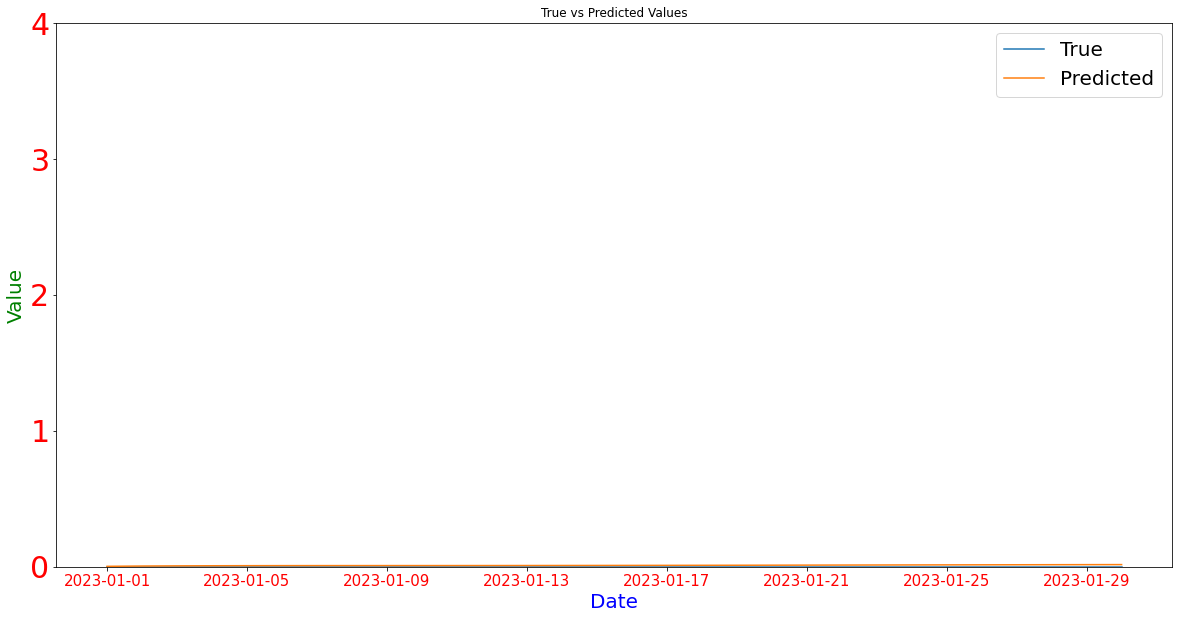

1/1 [==============================] - 0s 14ms/step
RMSE: 0.2898788200088431
R-squared: -0.7201934592257613


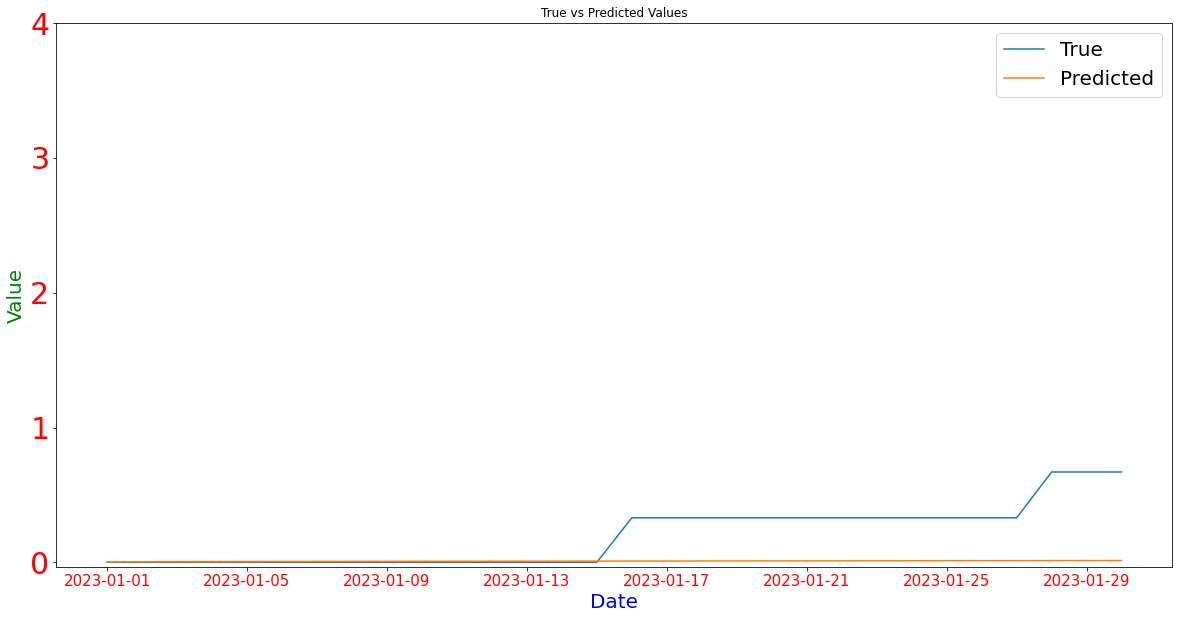

1/1 [==============================] - 0s 14ms/step
RMSE: 0.9549526017941273
R-squared: -1.643161485989999


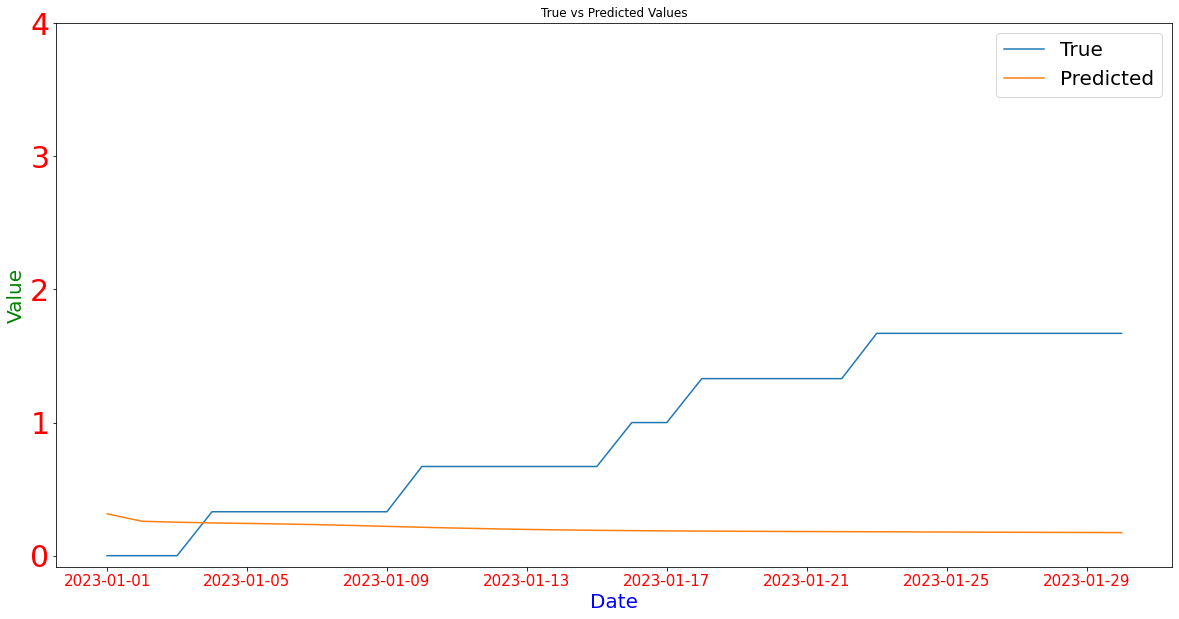

1/1 [==============================] - 0s 13ms/step
RMSE: 0.043833237582374535
R-squared: -1.7319850132590022e+28


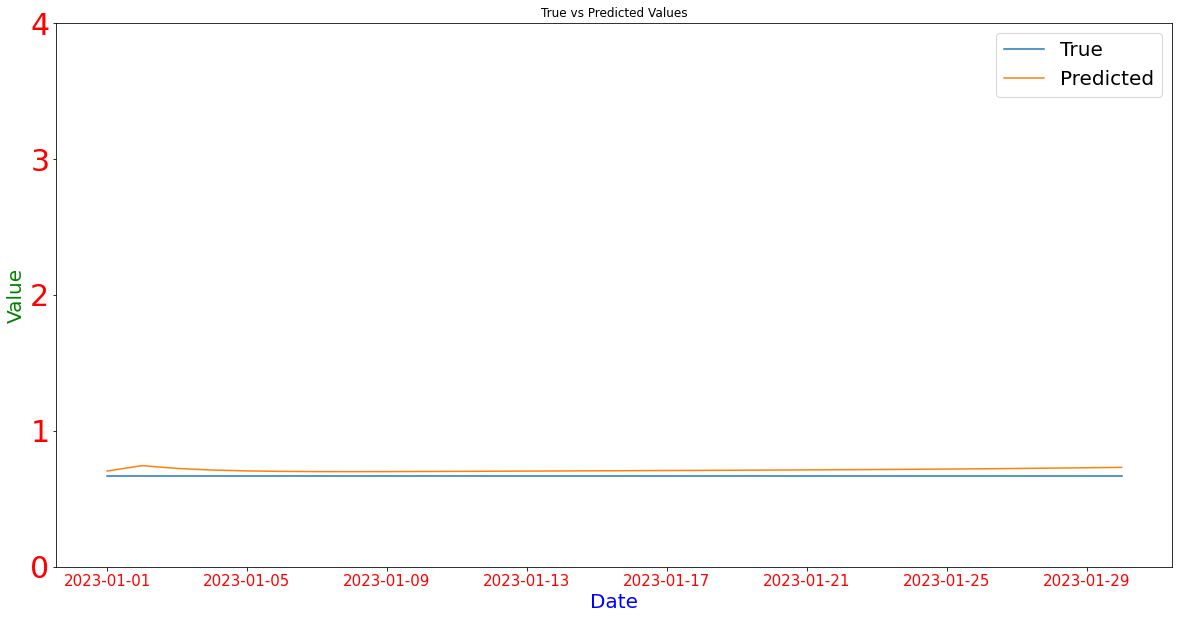

1/1 [==============================] - 0s 13ms/step
RMSE: 0.12506019778355973
R-squared: -0.005431983049768885


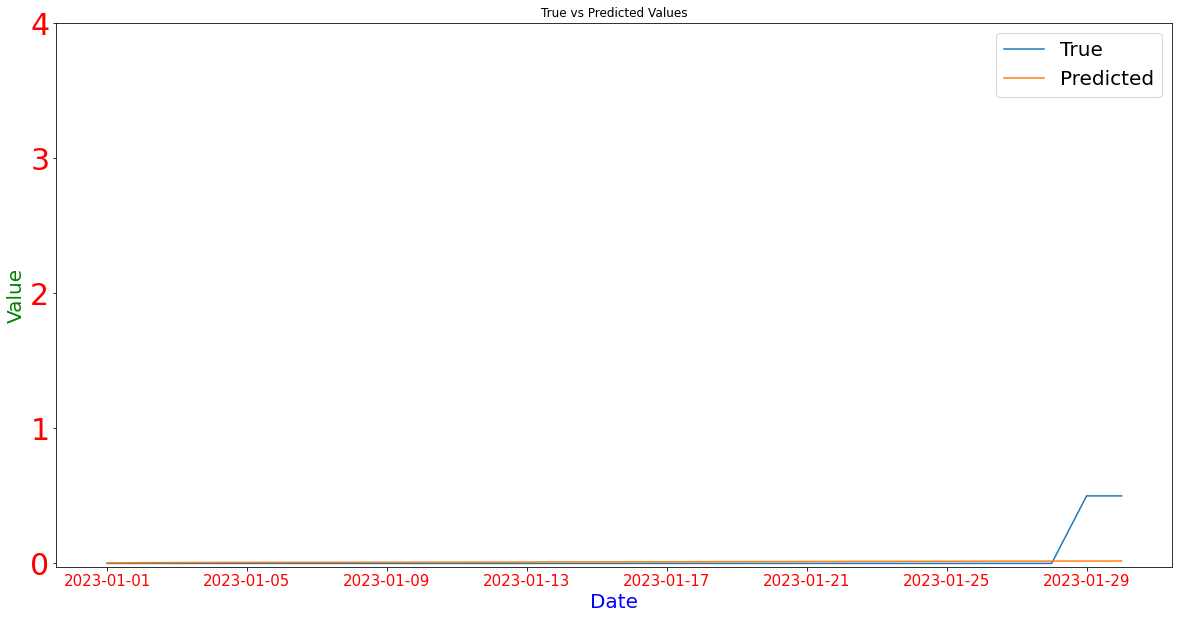

1/1 [==============================] - 0s 13ms/step
RMSE: 0.3624686906405768
R-squared: -0.5677313511970228


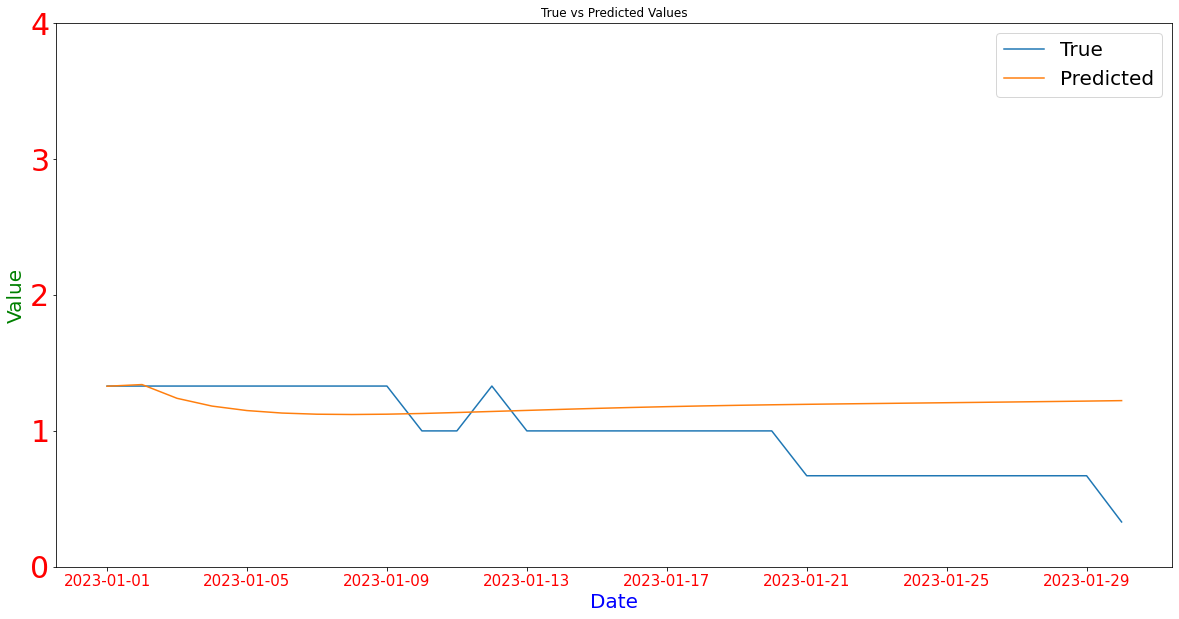

1/1 [==============================] - 0s 14ms/step
RMSE: 0.5404515334325073
R-squared: -0.05833152766794503


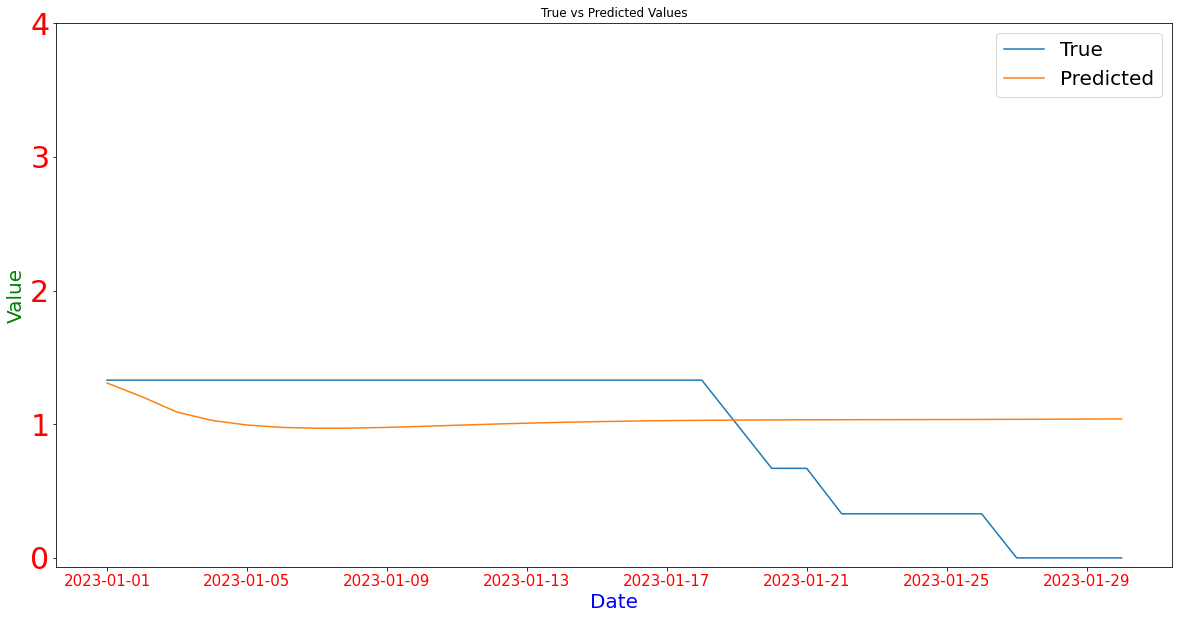

1/1 [==============================] - 0s 13ms/step
RMSE: 0.30119843885569014
R-squared: -1.1377073500878256


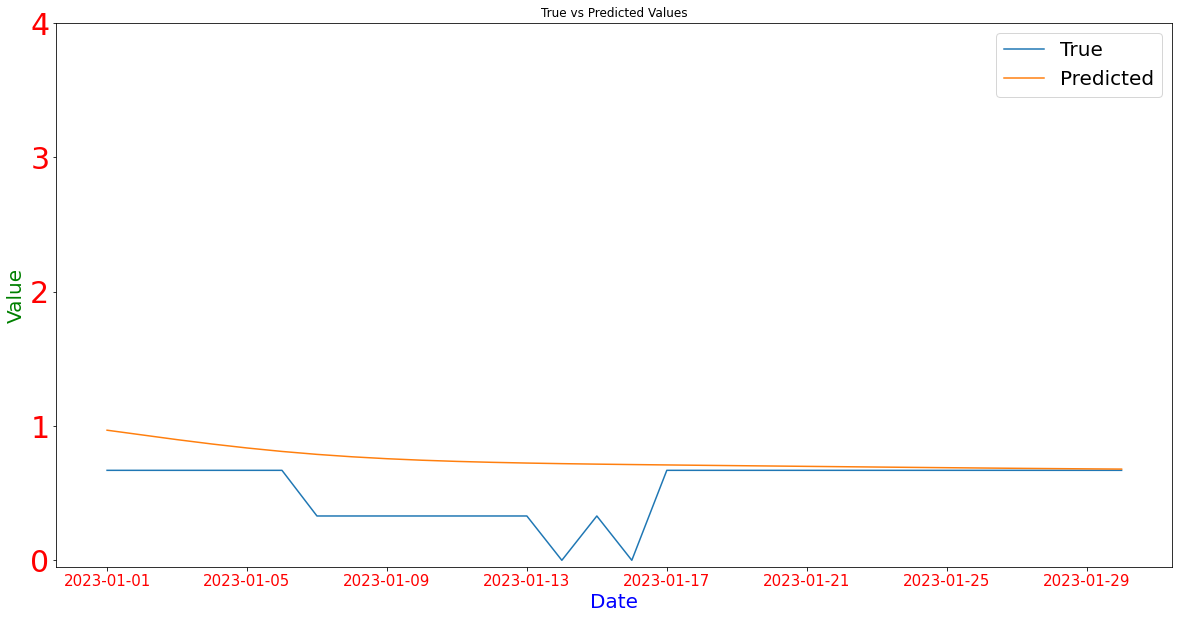

1/1 [==============================] - 0s 14ms/step
RMSE: 0.02648774381039236
R-squared: 0.0


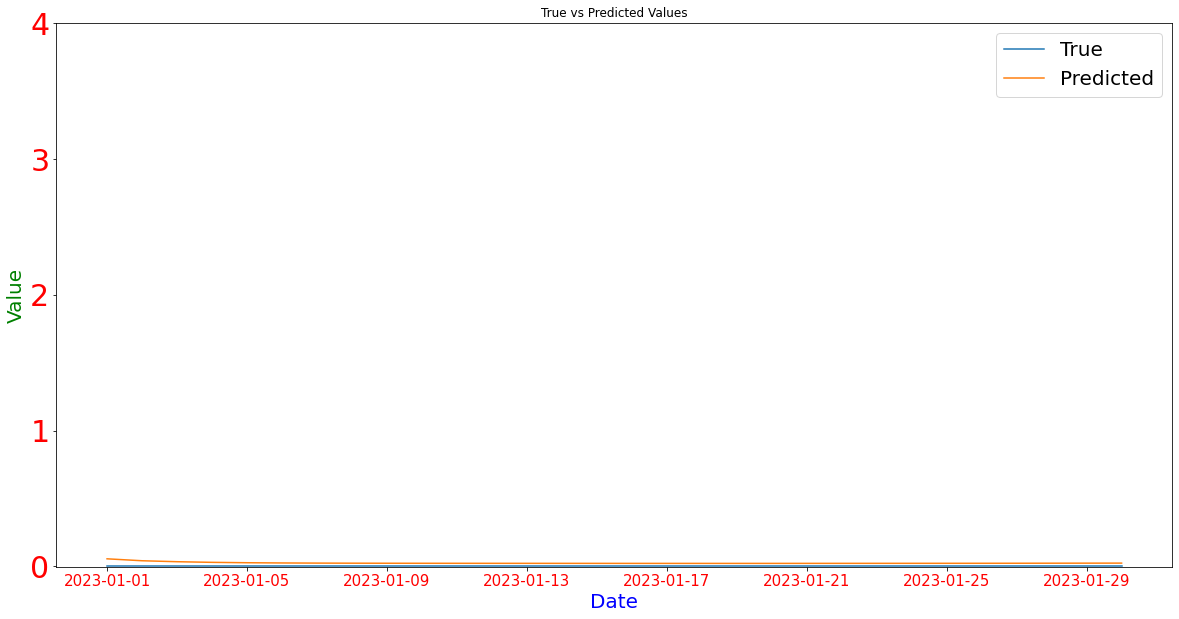

1/1 [==============================] - 0s 14ms/step
RMSE: 0.014792149406434446
R-squared: 0.0


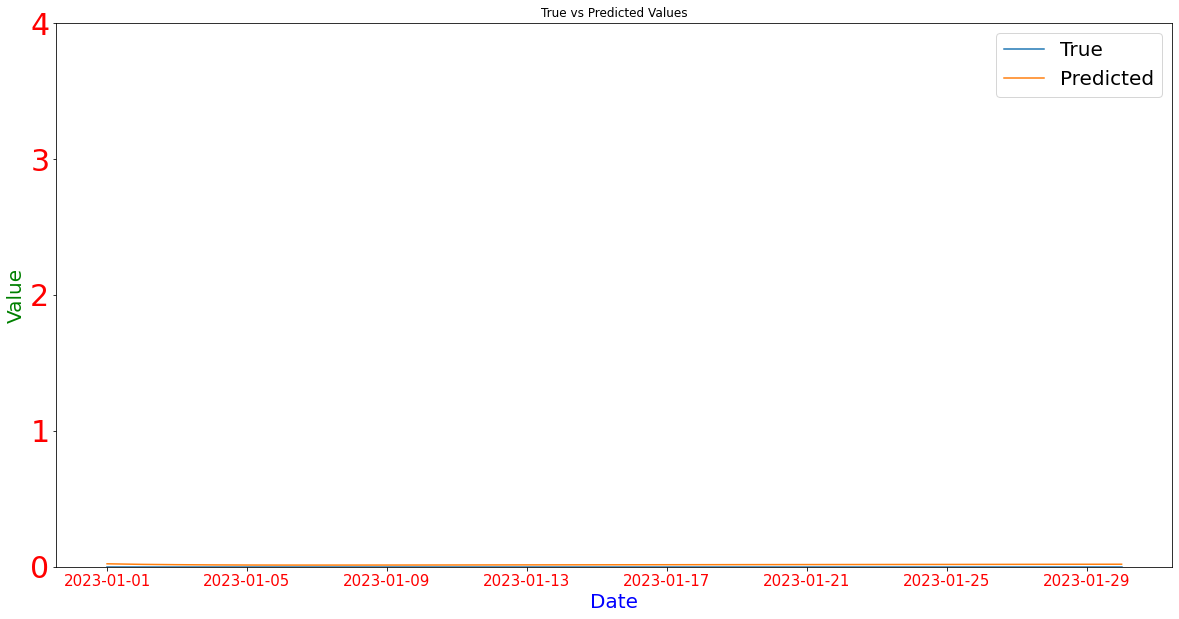

1/1 [==============================] - 0s 13ms/step
RMSE: 0.2841501318231781
R-squared: -3.6339128452209284


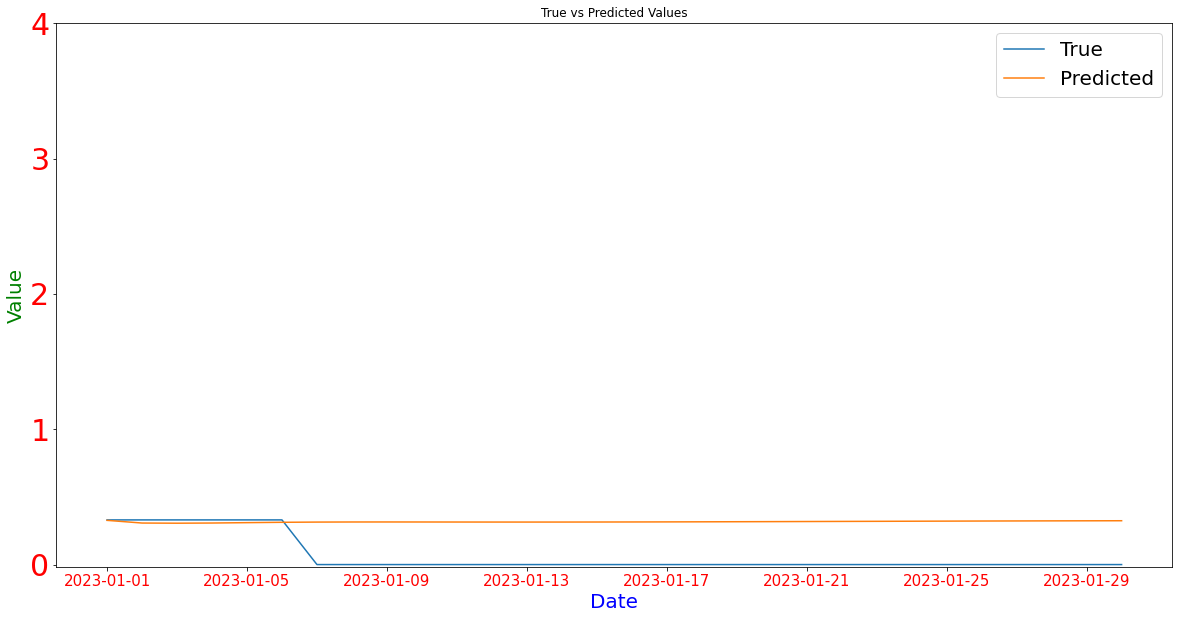

1/1 [==============================] - 0s 13ms/step
RMSE: 0.10129141549916815
R-squared: -0.046826941518734566


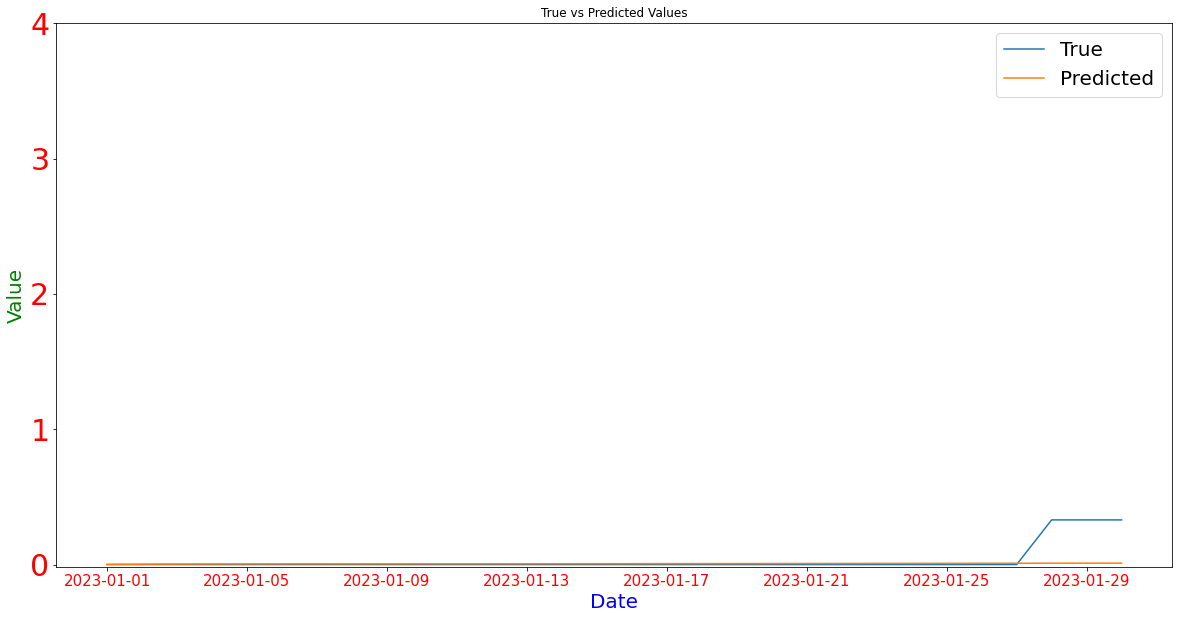

1/1 [==============================] - 0s 13ms/step
RMSE: 0.6836039320841637
R-squared: -0.1615549516118877


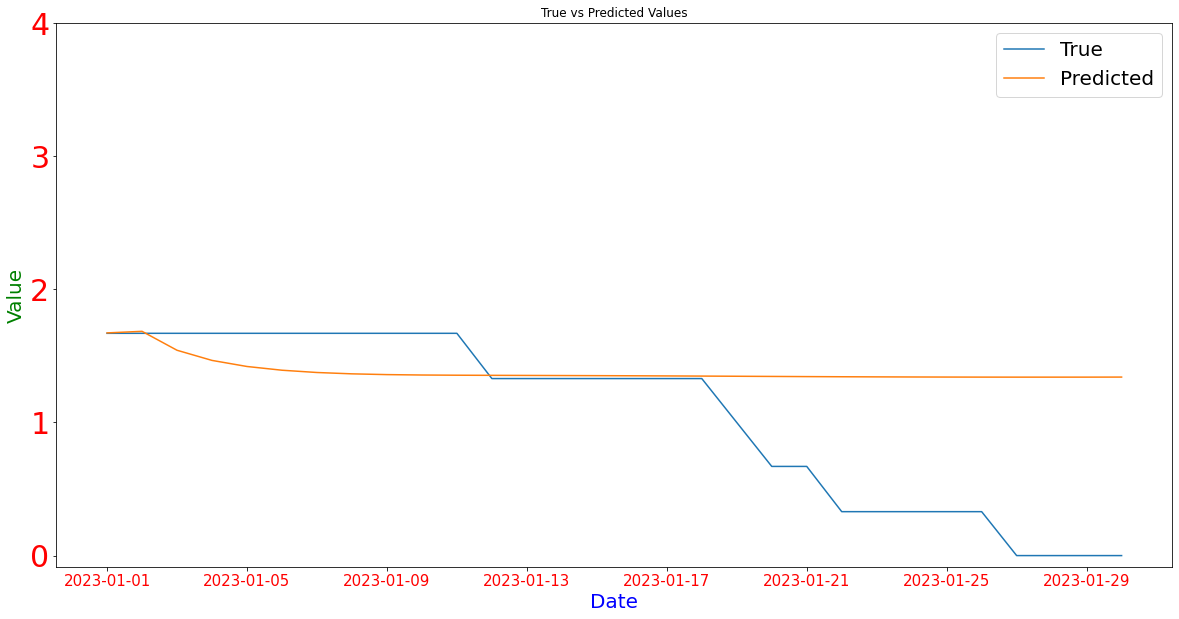

1/1 [==============================] - 0s 13ms/step
RMSE: 0.20538885963474507
R-squared: -0.6421334470525486


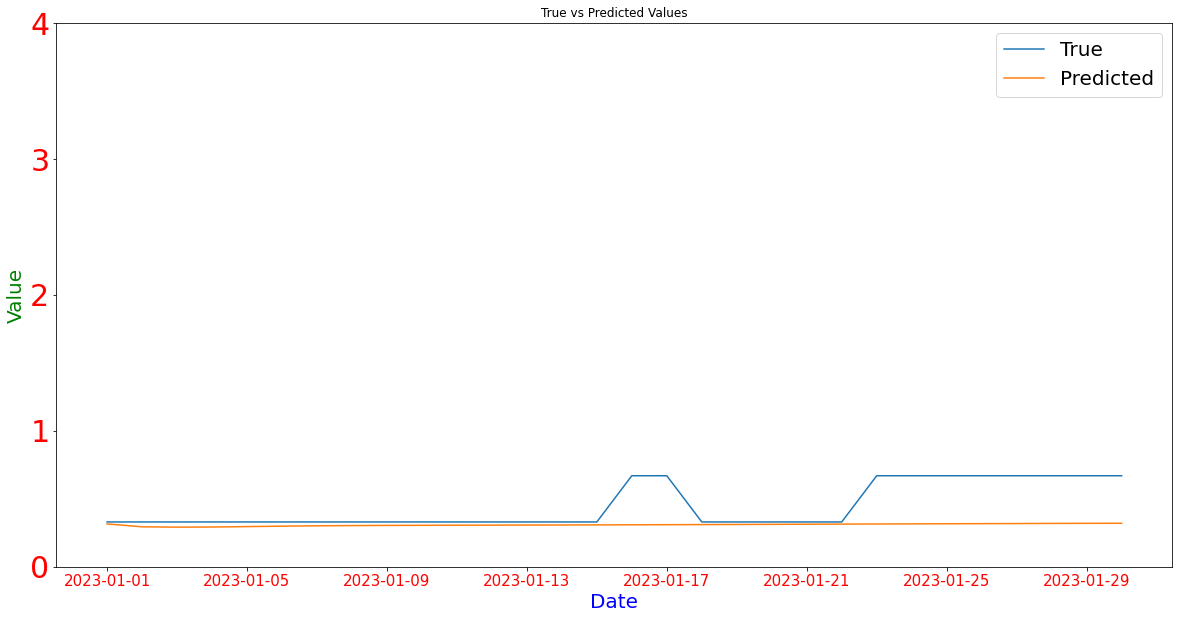

1/1 [==============================] - 0s 13ms/step
RMSE: 0.7993598511444407
R-squared: -0.3563685291414209


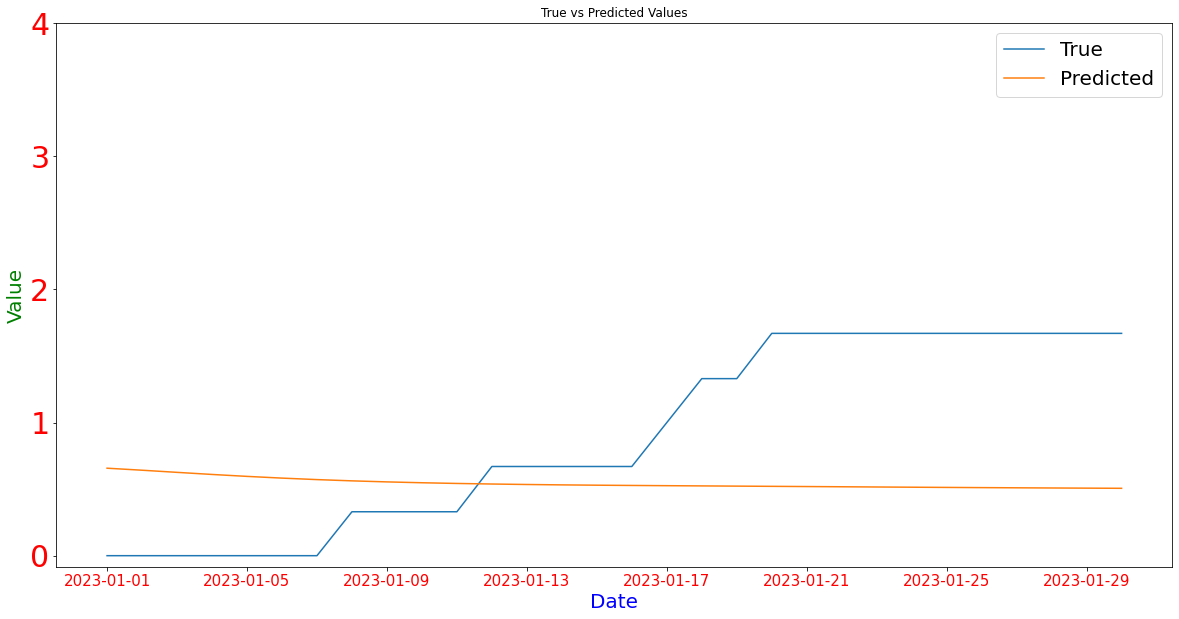

1/1 [==============================] - 0s 14ms/step
RMSE: 0.19019321752786458
R-squared: -4.3384681218420305


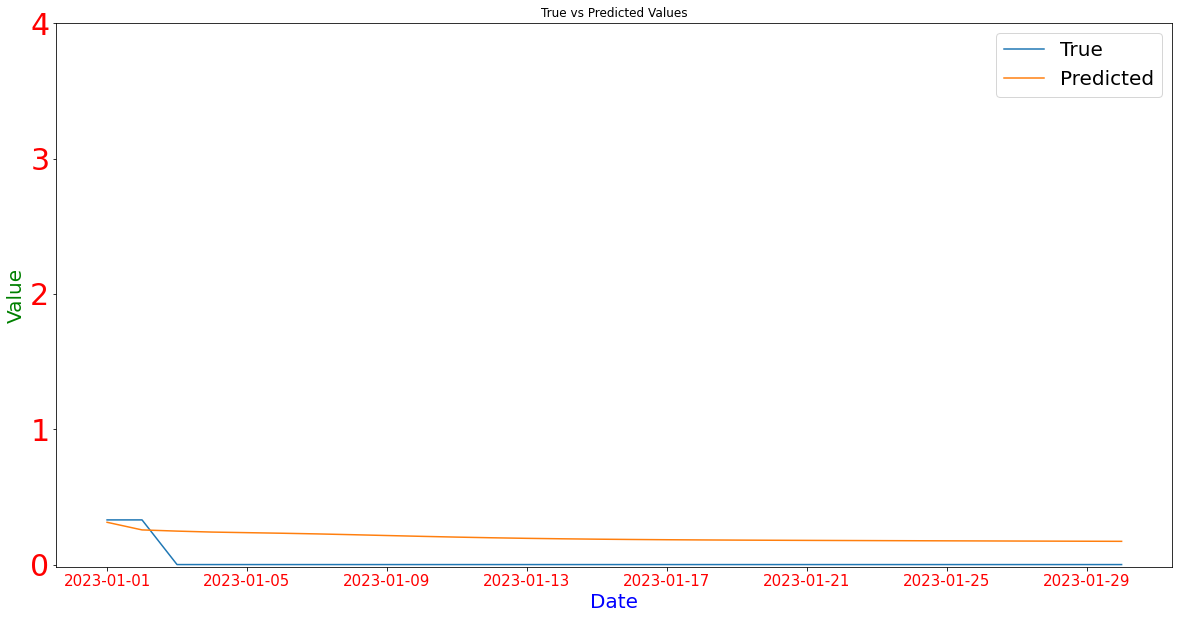

1/1 [==============================] - 0s 14ms/step
RMSE: 0.5860150982588729
R-squared: -2.0600462943849984


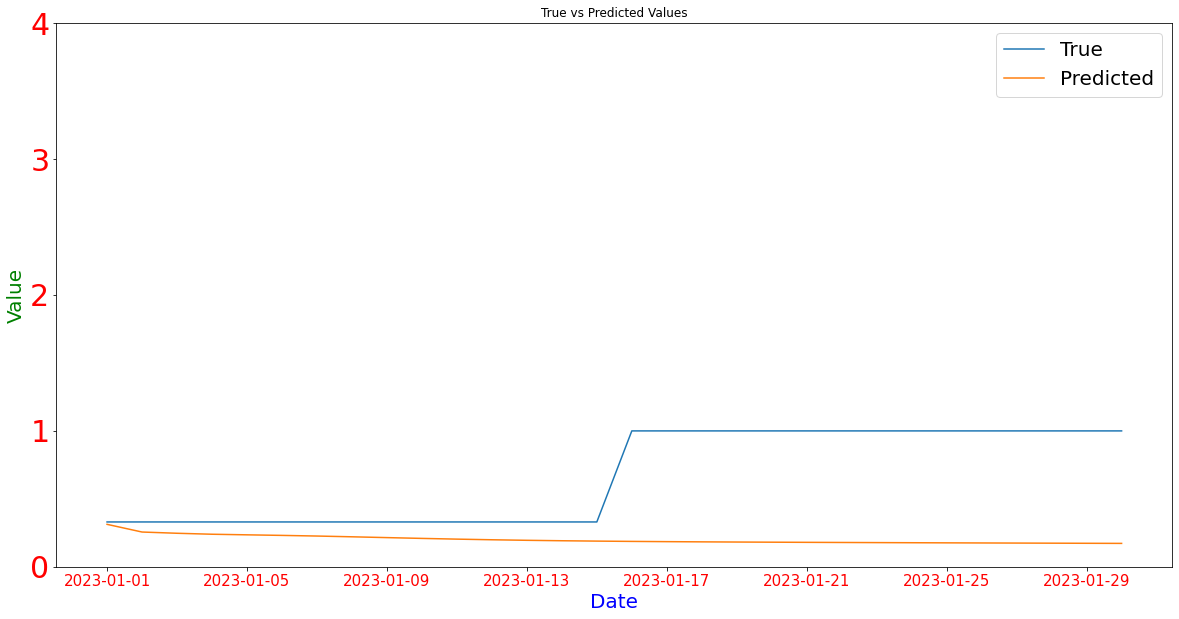

1/1 [==============================] - 0s 14ms/step
RMSE: 0.5172780593978481
R-squared: -0.19975394851907424


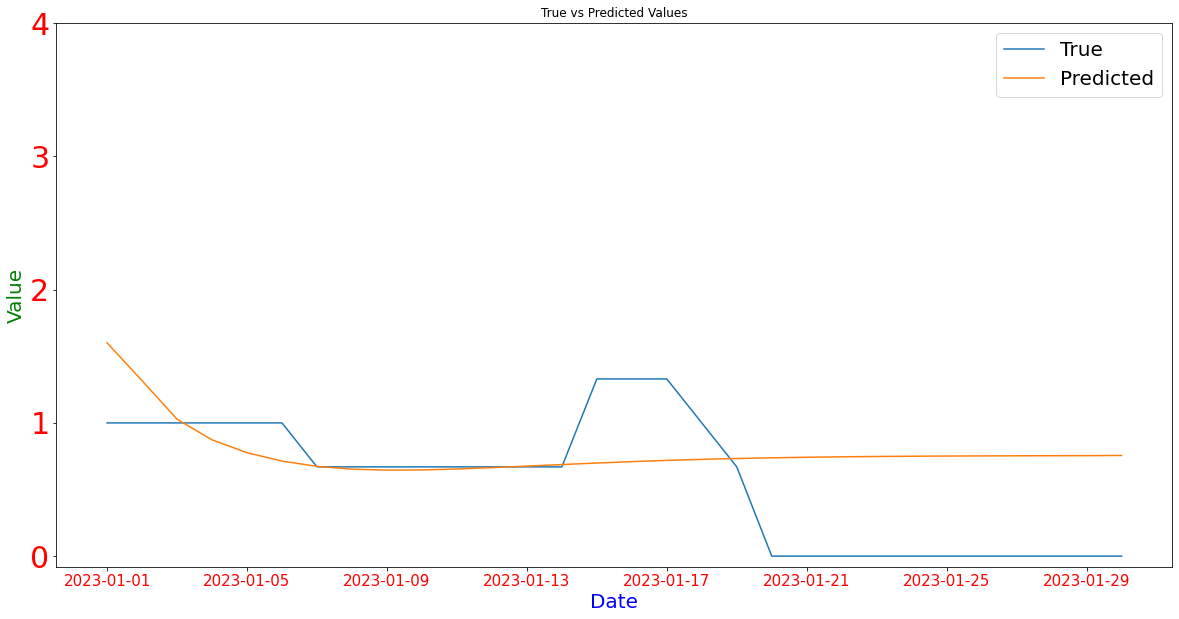

1/1 [==============================] - 0s 14ms/step
RMSE: 0.022377451339257212
R-squared: 0.0


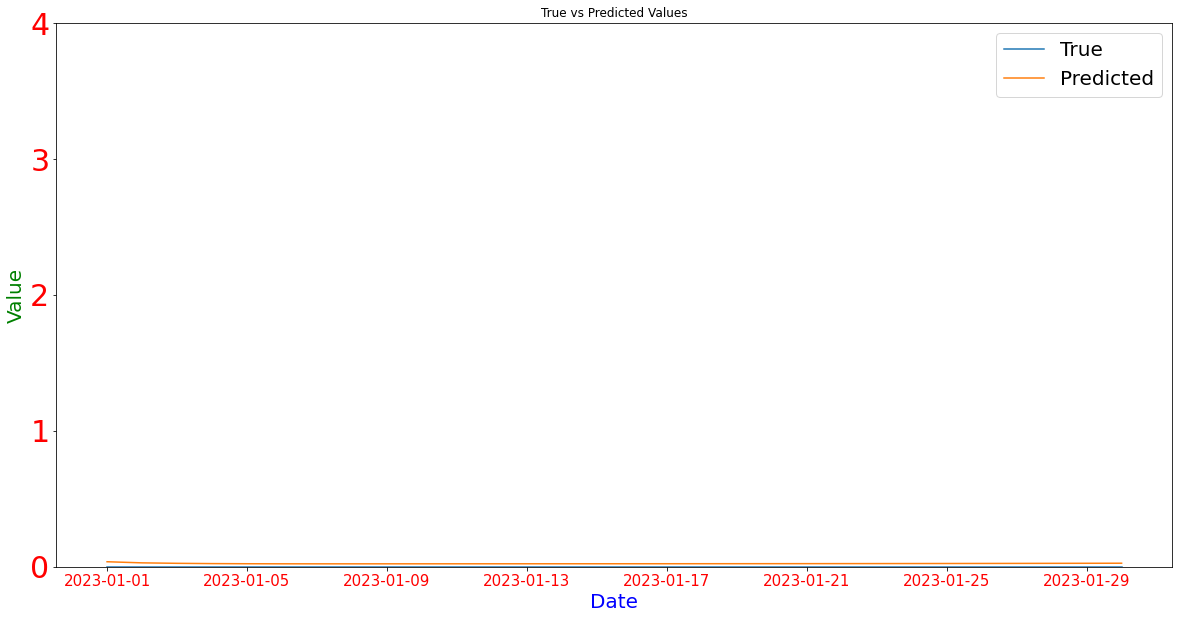

In [49]:
directory = f'{os.getcwd()}\\model_save\\prediction_result_30\\DSCI'
start_date = datetime.strptime('2023-01-01', '%Y-%m-%d').date()
start_date = pd.to_datetime(start_date)
end_date = datetime.strptime('2023-01-30', '%Y-%m-%d').date()
end_date = pd.to_datetime(end_date)


file_list = os.listdir(directory)
window_size = 30
for file_name in file_list:
    model = load_model(f'{directory}\\{file_name}') # we import the model here
    city = int(file_name.split('_')[0]) # we get city code here
    true_data_for_prediction = df_DSCI[(df_DSCI['grid'] == city) & (df_DSCI['date'] >= start_date) & (df_DSCI['date'] <= end_date)][['date','value']]
    true_data_for_prediction.reset_index(drop=True,inplace=True)
    df = output_dict[city].copy()
    df = df[['date','value_DSCI']]
    df.set_index('date', inplace=True)
    df = df['value_DSCI'].astype(float)
    df = pd.DataFrame(df)
    input_data = df['value_DSCI'].iloc[-window_size:]  # Extract last 30 days' data
    input_data = input_data.to_numpy().reshape(-1, 1)
    sc = MinMaxScaler()
    input_data_transformed = sc.fit_transform(input_data)
    X_pred = np.reshape(input_data_transformed, (1, window_size, 1))



    # Predict the next 30 days of level_DSCI
    predicted_values = []
    for _ in range(30):
        y_pred_30 = model.predict(X_pred)
        input_data = np.concatenate([input_data, y_pred_30], axis=0)
        y_pred_30 = sc.inverse_transform(y_pred_30)
        predicted_values.append(y_pred_30[0][0])
        # Append the predicted value to the dataset for the next iteration
        # new_row = pd.DataFrame([y_pred_30[0][0]], columns=['value_DSCI'])['value_DSCI']
        # Update input_data for the next iteration
        input_data_2 = input_data[-window_size:]
        X_pred = np.reshape(input_data_2, (1, window_size, 1))  

    # model evaluation
    True_array = np.array(true_data_for_prediction['value']).reshape((30, 1))
    pred_array = np.array(predicted_values)
    mse = mean_squared_error(True_array, pred_array)
    rmse = np.sqrt(mse)
    print('RMSE:', rmse)
    r2 = r2_score(True_array, pred_array)
    print('R-squared:', r2)
    
    predicted = pd.DataFrame(predicted_values)
    final_df = pd.concat([true_data_for_prediction, predicted] ,axis=1)
    final_df.reset_index(drop=True,inplace=True)
    final_df = final_df.rename(columns={0: 'Predicted_value_DSCI','value':'True_value_DSCI'})
    final_df['Predicted_value_DSCI'] = final_df['Predicted_value_DSCI'].astype('float')
    final_df['True_value_DSCI'] = final_df['True_value_DSCI'].astype('float')
    final_df = final_df[['date','True_value_DSCI','Predicted_value_DSCI']]
    final_df.to_csv(f'{os.getcwd()}//tem//DSCI_prediction_30//{city}__rmse_{round(rmse,2)}_r2_{round(r2,2)}_DSCI.csv')


    plt.figure(figsize=(20, 10))
    # Plot the 'true' and 'predict' values against the 'date' column
    plt.plot(final_df['date'], final_df['True_value_DSCI'], label='True',)
    plt.plot(final_df['date'], final_df['Predicted_value_DSCI'], label='Predicted')
    # Set the x-axis label, y-axis label, and title of the plot
    plt.xlabel('Date', color='blue',size=20)
    plt.ylabel('Value', color='green',size=20)
    plt.title('True vs Predicted Values')
    plt.xticks(color='#f00',
            fontsize=15) 
    plt.yticks(ticks=[0,1,2,3,4],color='#f00',
            fontsize=30) 
    plt.legend(fontsize="20")
    # Display the plot
    plt.show()

    # Print the predicted values



